# 0.1 Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import category_encoders as ce

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from boruta import BorutaPy

## 0.1.1 Loading datasets

In [2]:
raw_train = pd.read_csv('../data/raw/train.csv')

# 1.0 Data description 

## 1.1 Checking dataset shape and columns

In [3]:
raw_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
raw_train.shape

(381109, 12)

In [5]:
raw_train.columns = [col.lower().replace(' ','_') for col in raw_train.columns]

## 1.2 Checking data types

In [6]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [7]:

raw_train['region_code'] = raw_train['region_code'].astype('int')
raw_train['policy_sales_channel'] = raw_train['policy_sales_channel'].astype('int')
raw_train['gender'] = raw_train['gender'].astype('category')
raw_train['vehicle_damage'] = raw_train['vehicle_damage'].astype('category')

## 1.3 Checking missing or unsupported data 

<Axes: >

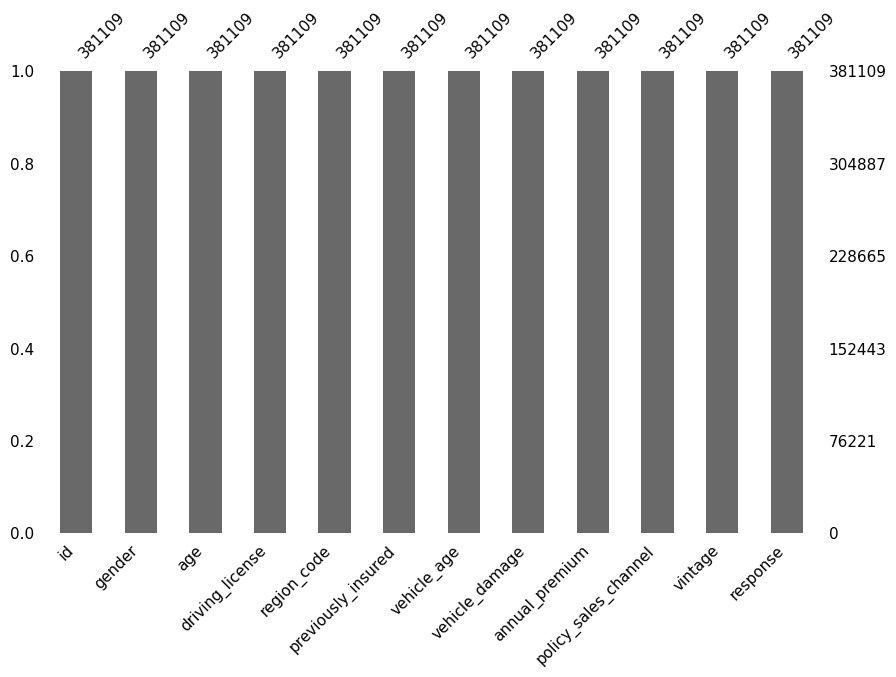

In [8]:
msno.bar(raw_train, figsize=(10,6), fontsize=11)

In [9]:
vehicle_dmg = raw_train['vehicle_damage'].str.count(r'[^a-zA-Z0-9\s]').sum()
gender = raw_train['gender'].astype('str').str.count(r'[^a-zA-Z0-9\s]').sum()

print(f'\'vehicle_damage\' special characters: {vehicle_dmg} \n\'gender\' special characters: {gender}')


'vehicle_damage' special characters: 0 
'gender' special characters: 0


## 1.4 Descriptive analysis 

In [10]:
raw_train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0


In [11]:
num_features = raw_train.select_dtypes(include=['int64','float64'])
cat_features = raw_train.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [12]:
kurt_skew = num_features.apply(lambda x: x.agg(['kurtosis', 'skew'])).T
df_describe = num_features.describe().T

df_stats = pd.concat([df_describe, kurt_skew], axis=1)
df_stats  

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,-1.200000,9.443274e-16
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,-0.565655,6.725390e-01
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,464.354302,-2.159518e+01
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-0.867857,-1.152664e-01
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,-1.971871,1.677471e-01
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,34.004569,1.766087e+00
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-0.970810,-9.000081e-01
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,-1.200688,3.029517e-03
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298788,2.301906e+00


---

# 2.0 Data Preparation

In [13]:
raw_train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0


In [14]:
X = raw_train.drop(['id','response'], axis=1)
y = raw_train['response'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## 2.1 Encoding

In [15]:
# Target encoding (James-Stein)
tg_enc_gender = ce.JamesSteinEncoder(cols=['gender'])
X_train['gender'] = tg_enc_gender.fit_transform(X= X_train[['gender']], y= y_train)

# Target encoding (James-Stein) 
tg_enc_region_code = ce.JamesSteinEncoder(cols=['region_code'])
X_train['region_code'] = tg_enc_region_code.fit_transform(X= X_train[['region_code']], y= y_train)

# One-Hot encoding
X_train = pd.get_dummies(X_train, columns= ['vehicle_age'], prefix= 'vehicle_age', dtype=int)

# Label encoding
X_train['vehicle_damage'] = X_train['vehicle_damage'].map({'Yes':1,'No':0})

# Frequency encoding
fe_policy_sales_channel = X_train['policy_sales_channel'].value_counts(normalize=True)
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].map(fe_policy_sales_channel)

## 2.2 Rescaling

In [16]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

X_train['age'] = mms_age.fit_transform(X_train[['age']].values)
X_train['vintage'] = mms_age.fit_transform(X_train[['vintage']].values)


## 2.3 Standartization

In [17]:
# annual_premium
ss = StandardScaler()
X_train['annual_premium'] = ss.fit_transform(X_train[['annual_premium']].values)

## 2.4 Validation Preparation

In [18]:
# Target encoding (James-Stein)
X_val['gender'] = tg_enc_gender.transform(X= X_val[['gender']], y= y_val)

# Target encoding (James-Stein) 
X_val['region_code'] = tg_enc_region_code.transform(X= X_val[['region_code']], y= y_val)

# One-Hot encoding
X_val = pd.get_dummies(X_val, columns= ['vehicle_age'], prefix= 'vehicle_age', dtype=int)

# Label encoding
X_val['vehicle_damage'] = X_val['vehicle_damage'].map({'Yes':1,'No':0})

# Frequency encoding
fe_policy_sales_channel = X_val['policy_sales_channel'].value_counts(normalize=True)
X_val['policy_sales_channel'] = X_val['policy_sales_channel'].map(fe_policy_sales_channel)

# Rescaling ---------------

X_val['age'] = mms_age.transform(X_val[['age']].values)
X_val['vintage'] = mms_age.transform(X_val[['vintage']].values)

# Standartzation ---------------

X_val['annual_premium'] = ss.transform(X_val[['annual_premium']].values)


## 2.5 Feature Selection

In [19]:
X_full = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

X_full.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
0,0.138457,0.384615,1,0.123613,0,1,0.713050,0.193550,0.359862,1,0,0
1,0.138457,0.461538,1,0.105981,0,1,0.378965,0.209035,0.584775,1,0,0
2,0.138457,0.276923,1,0.150906,0,1,0.380761,0.209035,0.204152,1,0,0
3,0.103900,0.169231,1,0.123613,0,1,-1.618826,0.209035,0.328720,0,1,0
4,0.103900,0.384615,1,0.090900,0,1,-0.462360,0.193550,0.643599,1,0,0


In [20]:
class FeatureSelection:
    def __init__(self):
        self.forest = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, verbose=1 ,random_state=0)
           
    def feature_importance(self, X, y):     
        self.forest.fit(X, y)
        importances = self.forest.feature_importances_

        df = pd.DataFrame({'feature': X.columns.to_list(), 
                           'importance': importances
                         }).sort_values(by='importance', ascending=False).reset_index(drop=True)    
        return df
    
    def plot_feature_importance(self, df):
        plt.figure(figsize=(10,6))
        plt.title('Feature Importance')
        plt.ylabel('Features', fontsize=12)
        plt.xlabel('Importance', fontsize=12)
        sns.barplot(data=df, x='importance', y='feature',orient='h', palette='viridis', hue='feature', legend=False)
        plt.show()

In [23]:
fs = FeatureSelection()
feat_importance = fs.feature_importance(X_full, y_full)
feat_importance

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   54.5s finished


,feature,importance
0,vintage,0.264938
1,annual_premium,0.238240
2,age,0.175594
3,region_code,0.102152
4,vehicle_damage,0.069064
5,policy_sales_channel,0.067258
6,previously_insured,0.055299
7,vehicle_age_< 1 Year,0.013572
8,vehicle_age_1-2 Year,0.006493
9,gender,0.004678


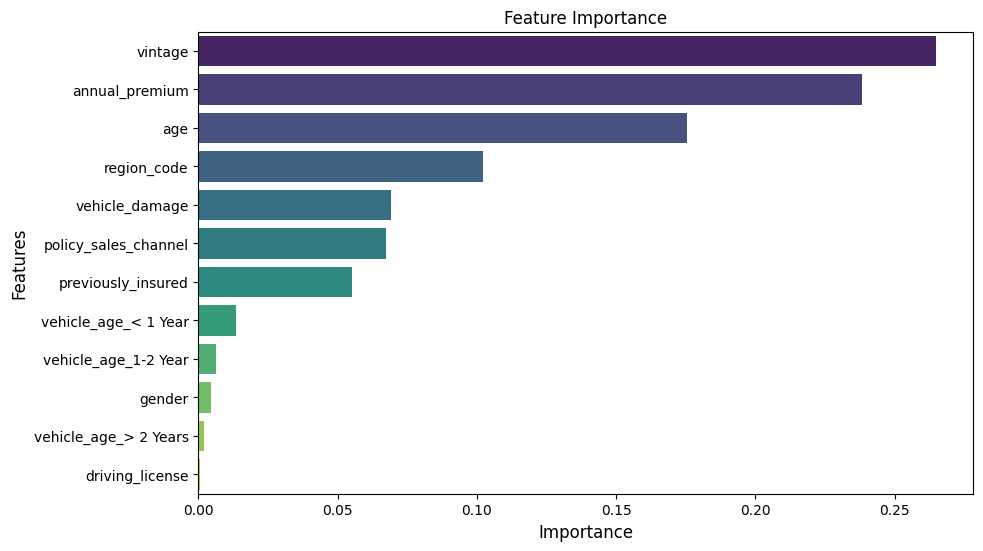

In [24]:
fs.plot_feature_importance(feat_importance)

In [21]:
# X_train_full = pd.concat([X_train, y_train], axis=1)
# X_val_full = pd.concat([X_val, y_val], axis=1)

In [22]:
# # Saving processed data for modeling
# X_train_full.to_csv('../data/processed/train.csv', index=False)
# X_val_full.to_csv('../data/processed/validation.csv', index=False)